In [189]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import torch.nn as nn
import torch
import math
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from typing import List
import copy
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#local
dataFolder = os.path.join(os.getcwd(),"Data")
#Kaggle
#dataFolder = "/kaggle/input/titanic"
for dirname, _, filenames in os.walk(dataFolder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
        
RANDOM_SEED = 41
torch.manual_seed(RANDOM_SEED)

c:\Dev\Titanic\Data\submission.csv
c:\Dev\Titanic\Data\test.csv
c:\Dev\Titanic\Data\train.csv


Some Helper Functions

In [190]:
def printUniqueCounts(df, columnName: str = None):
    column = None
    if columnName is None:
        column = df
    else:
        column = df[columnName]
    titles = column.unique()
    counts = []
    for title in titles:
        if pd.isna(title):
            count = sum(column.isnull())
        else:
            count = sum(column==title)
        counts.append([title,count])
    
    counts.sort(key=lambda x: -x[1])
    
    for item in counts:
        print(str(item[0])+": "+str(item[1]))

def torchEnumerator(tensor):
    array = tensor.detach().numpy()
    print("shape" + str(array.shape))
    return np.nditer(array)

In [191]:
trainFilePath = os.path.join(dataFolder,'train.csv')
trainData = pd.read_csv(trainFilePath)
print(trainData.shape)
trainDataRows = trainData.shape[0]
trainData.head()


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We will concat the test data to the training Data, so that all data manipulation happens to both data sets

In [192]:
testFilePath = os.path.join(dataFolder,'test.csv')
testData = pd.read_csv(testFilePath)
testDataRows = testData.shape[0]
trainData = pd.concat([trainData,testData])

Now it's time to clean up the data for use with our ML algorithm and do some feature engineering.

First lets see which columns have NaN / null values:

In [193]:
for column in trainData.columns:
    empty = len(trainData[trainData[column].isnull()])
    if empty>0: print(column + " has " + str(empty) + " missing data points")

Survived has 418 missing data points
Age has 263 missing data points
Fare has 1 missing data points
Cabin has 1014 missing data points
Embarked has 2 missing data points


We will fill in missing age values with average age for now. In the future we may want to infer the age from the other columns, but for now this will have to suffice.

In [194]:
#fill in missing age values with average age
avgAge = trainData["Age"].mean()
print(F"Average age: {avgAge}")
trainData["Age"].fillna(avgAge, inplace=True)

Average age: 29.881137667304014


To gain a better idea of how to handle the missing values in embarked, lets first see how many people embarked from each port:

In [195]:

printUniqueCounts(trainData,"Embarked")

S: 914
C: 270
Q: 123
nan: 2


For the two passengers with unknown ports of embarcation, lets simply fill in the data with the most likely possibility: S

In [196]:
trainData["Embarked"].fillna("S", inplace=True)

There are only 3 ports of embarcation, which makes this feature a good candidate for one-hot encoding. Missing values will simply be recorded as 'False' in all embarcation ports

In [197]:
trainData = pd.get_dummies(trainData,columns=["Embarked"])
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,False,False,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,True,False,False
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,False,True
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,False,False,True
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,False,False,True


The remaining column with missing data is Cabin. This is really two features: cabin area (the letter) and cabin number (the integer). For the sake of simplicity, lets assume the cabin number is not useful, but that the cabin area is. This is a reasonable assumption because the cabin area is likely to have a large effect on the location of the passenger, whereas the cabin number is less likely to have a large effect.

In [198]:

def getCabinLetter(cabin: str):
    if cabin is None or not isinstance(cabin,str): return None
    result =  re.search("^[a-zA-Z]*",cabin)
    if not result: return None
    return result[0]
    
cabinLetter = trainData["Cabin"].apply(getCabinLetter)

print("Cabin Letters")
printUniqueCounts(cabinLetter)


Cabin Letters
None: 1014
C: 94
B: 65
D: 46
E: 41
A: 22
F: 21
G: 5
T: 1


We can see there are only 8 valid options for cabin letter. Being a small number this is a good candidate for one-hot encoding, again solving the missing data issue.

In [199]:
trainData["Cabin"] = cabinLetter
trainData = pd.get_dummies(trainData,columns=["Cabin"])
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,False,True,False,False,False,False,False,False,False,False
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,False,False,False,False,True,False,False,False,False,False
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,False,True,False,False,False,False,False,False,False,False
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,False,True,False,False,True,False,False,False,False,False
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,False,True,False,False,False,False,False,False,False,False


That covers all the missing data, so now we just need to deal with non-numeric data. Lets start by converting Male/Female and True/False to 0/1

In [200]:
trainData["Sex"] = trainData["Sex"]=="male"
trainData = trainData*1
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,0,1,0,0,0,0,0,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,1,0,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0,0,0,0,0,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,0,1,0,0,1,0,0,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,0,1,0,0,0,0,0,0,0,0


Name and Ticket remain as non-numeric data. We probably could do some NLP to make useful inferences out of the names, but that would be a lot of work and likely not yield a big difference in results. Ticket is also likely not to be very useful info. So lets just delete both columns.

In [201]:
trainData = trainData.drop(columns=["Name","Ticket","PassengerId"])
trainData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0.0,3,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,0,0
1,1.0,1,0,38.0,1,0,71.2833,1,0,0,0,0,1,0,0,0,0,0
2,1.0,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,0
3,1.0,1,0,35.0,1,0,53.1000,0,0,1,0,0,1,0,0,0,0,0
4,0.0,3,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,0


In [202]:
printUniqueCounts(trainData,"Survived")

0.0: 549
nan: 418
1.0: 342


Now lets do a little bit of feature engineering. Most of these features look pretty useful as is, but Sibsp and Parch stand out as being a potentially useful target for a little bit of engineering. 
SibSp: siblings and spouses
Parch: parents and children

We can combine these two to get family size. Total family size might be an important metric so lets make an additional column for family size 

In [203]:

trainData.insert(len(trainData.columns),"FamSize",trainData["SibSp"]+trainData["Parch"])
trainData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,FamSize
0,0.0,3,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,0,0,1
1,1.0,1,0,38.0,1,0,71.2833,1,0,0,0,0,1,0,0,0,0,0,1
2,1.0,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,1,0,35.0,1,0,53.1000,0,0,1,0,0,1,0,0,0,0,0,1
4,0.0,3,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,0,0,0


To complete our feature engineering we will to normalize the data. Lets use zscore normalization on Age and Fare:

In [204]:
colsToNormalize = ["Age","Fare"]
scalers = {}
for col in colsToNormalize:
    scaler = StandardScaler()
    scalers[col] = scaler
    colData = trainData[col].values.reshape(-1,1)
    scaler.fit(colData)
    trainData[col] = scaler.transform(colData)
trainData.head()




,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,FamSize
0,0.0,3,1,-0.611972,1,0,-0.503402,0,0,1,0,0,0,0,0,0,0,0,1
1,1.0,1,0,0.630431,1,0,0.734222,1,0,0,0,0,1,0,0,0,0,0,1
2,1.0,3,0,-0.301371,0,0,-0.490356,0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,1,0,0.397481,1,0,0.382778,0,0,1,0,0,1,0,0,0,0,0,1
4,0.0,3,1,0.397481,0,0,-0.487940,0,0,1,0,0,0,0,0,0,0,0,0


Recall how we appended the test data to the training data in order to manipulate both sets simultaneously. Lets now undo that.

In [205]:
testData = trainData.tail(testDataRows)
trainData = trainData.head(trainDataRows)
testData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,FamSize
0,NaN,3,1,0.358655,0,0,-0.492208,0,1,0,0,0,0,0,0,0,0,0,0
1,NaN,3,0,1.329283,1,0,-0.508234,0,0,1,0,0,0,0,0,0,0,0,1
2,NaN,2,1,2.494035,0,0,-0.456291,0,1,0,0,0,0,0,0,0,0,0,0
3,NaN,3,1,-0.223721,0,0,-0.476102,0,0,1,0,0,0,0,0,0,0,0,0
4,NaN,3,0,-0.611972,1,1,-0.406039,0,0,1,0,0,0,0,0,0,0,0,2


And in order to train the model without overfitting, lets create a training data set and a test data set upon which to verify generalization. We will use a random subset of 20% of rows as test data and the last 80% of rows as training data. Lets write a class to handle our data storage and conversion to tensors

In [206]:
class DataSet:
    def __init__(self, X:torch.Tensor, Y:torch.Tensor):
        if X.shape[0] != Y.shape[0]:
            raise ValueError("Row count mismatch between X and Y")
        X.requires_grad_(True)
        self.X = X
        self.Y = Y
        self.usingCuda = False

    @staticmethod
    def FromDataFrames(X:pd.DataFrame, Y:pd.DataFrame)->'DataSet':
        def ToTensor(set):
            if set is None: return None
            return torch.tensor(set.values,dtype=torch.float32)
        return DataSet(ToTensor(X),ToTensor(Y))


    @property
    def InputCount(self):
        return self.X.shape[1]

    @property
    def Rows(self):
        return self.X.shape[0]

    def set_to_cuda(self):
        def update(set:torch.Tensor)->torch.Tensor:
            if set is None: return None
            return set.cuda_()
        
        self.X = update(self.X)
        self.Y = update(self.Y)
        self.usingCuda = True
                
    def subset(self,indices)->'DataSet':
        return DataSet(self.X[indices],self.Y[indices])

    def head(self,n=None)->'DataSet':
        if n is None: n = 5
        return self.subset([i for i in range(n)])
    
    def print(self,n=None):
        head = self.head(n)
        (x,y) = head.toNumpy()
        dfx = pd.DataFrame(x)
        dfy = pd.DataFrame(y)
        dfx["Y"] = dfy
        display(dfx)
    
    def toNumpy(self):
        def convert(tens):
            if self.usingCuda:
                tens = tens.cpu()
            return tens.detatch().numpy()
        return (convert(self.X),convert(self.Y))


    
    def sample_with_replacement(self, n=None):
        r = self.Rows
        if n is None:
            n = r
        sampleIndices = [random.randint(0, r-1) for _ in range(n)]
        # The following return statement is placeholder; adjust as needed.
        # You might need to use sampleIndices to create and return a new DataSet instance.
        return self.subset(sampleIndices)
        





Lets split the data between input (X) and output (Y) and divide it between training data and cross-validation data. We will store each dataset in an instance of the newly created dataset class. Let's alsp store the test data as a DataSet

In [207]:
def SeparateData(dataFrame:pd.DataFrame):
    yColName = "Survived"
    if yColName not in dataFrame.columns:
        Y = None
    else:
        Y= dataFrame[yColName]
    X = dataFrame.drop(columns=yColName)
    return (X,Y)

(X,Y) = SeparateData(trainData)
unsplitData = DataSet.FromDataFrames(X,Y)#save this for later

X,XVal,Y,YVal = train_test_split(X,Y,test_size=.2,random_state=RANDOM_SEED)
trainData = DataSet.FromDataFrames(X,Y)
valData = DataSet.FromDataFrames(XVal,YVal)



A quick test of the dataset sampling functionality:

In [208]:
# unitTestData = trainData.head(5)
# unitTestData.print()
# for i in range(3):
#     subset = unitTestData.sample_with_replacement()
#     subset.print()

Now we have prepared the data for our ML algorithm.

Lets create a decision tree ensemble and have it learn the data

In [209]:
class DecisionTreeEnsemble:
    def __init__(self,ensembleSize,baseTree:DecisionTreeClassifier):
        self.ensembleSize = ensembleSize
        trees = []
        for i in range(ensembleSize):
            tree = copy.copy(baseTree)#shallow copy to keep constructor vars
            trees.append(tree)
        self.trees = trees

    @property
    def _ensembleSize(self)->int: return len(self.trees)

    def learn(self,dataset:DataSet):
        for i in range(self._ensembleSize):
            set = dataset
            if i > 0: # for the first tree use the entire data set
                set = dataset.sample_with_replacement()
            tree = self.trees[i]
            tree.fit(set.X,set.Y)
    
    def _predict_separately(self,dataset:DataSet):
        predictions = []
        for tree in self.trees:
            predictions.append(np.array(tree.predict(dataset.X)))
        return predictions

    def _combine_predictions(self,predictions):
        predictions = np.array(x for x in predictions)
        predictions = np.transpose(predictions)
        predictions = np.mean(predictions,axis=1)
        return predictions
    
    def predict(self,dataset:DataSet):
        return self._combine_predictions(self._predict_separately(dataset))


SyntaxError: unexpected EOF while parsing (1677870580.py, line 10)

Some Helper functions for calculating accuracy, f1 score, etc..


In [ ]:
def getPrediction(yHat:np.array): 
    return (yHat>0.5).astype(int)

def accuracy(prediction:np.array,target:np.array): #arrays should be 0 or 1
    return (sum(prediction==target)/len(prediction)).item()
    
def f1Score(prediction:np.array,target:np.array):#arrays should be 0 or 1
    actualPositives = sum(target)
    predictedPositives = sum(prediction)
    truePositives = sum(target*prediction)
    if actualPositives == 0: 
        recall = 0
    else:
        recall = truePositives/actualPositives

    if predictedPositives == 0:
        precision = 0
    else:
        precision = truePositives/predictedPositives
    if precision == 0 or recall == 0:
        return 0
    f1 = 2/(1/precision+ 1/recall)
    return f1

And let's define a class for keeping track of training results

In [ ]:
class TrainingResult():
    def __init__(self):
        self.f1_score = []
        self.accuracy = []

class TrainingParams():
    def __init__(self):
        self.learningRate = 1e-2
        self.regularizationConstant = 1e-2
        self.iterations = 100

We'll define a function that we can use to train a model based on tweakable parameters:

In [ ]:

def trainModel(dataSets:List[DataSet], model:Model, loss_function:nn.modules.loss._Loss, trainingParams:TrainingParams)->List[TrainingResult]: 
    trainData = dataSets[0]
    print(F"Training Model. Features {trainData.InputCount}, Samples {trainData.Rows}. Iterations: {trainingParams.iterations}")



    results:List[TrainingResult] = []
    for _ in dataSets:
        results.append(TrainingResult())

    optimizer = torch.optim.Adam(params=model.parameters(),lr=trainingParams.learningRate,weight_decay=trainingParams.regularizationConstant)

    if torch.cuda.is_available():
        for set in dataSets:
            set.set_to_cuda()
        model.set_to_cuda()
        print(F"Running on {torch.cuda.get_device_name(torch.cuda.current_device())}")
    else:
        print("Running on CPU")
    

    for _ in range(trainingParams.iterations):
        trainingLoss = None
        for (set,result) in  zip(dataSets,results):
            x = set.get(DataSet.X)
            y = set.get(DataSet.Y)
            yHat = model.forward(x)

            l = loss_function(yHat,y)
            if trainingLoss is None: trainingLoss = l
            result.loss.append(l.item())

            y = convertOutput(y)
            yHat = convertOutput(yHat)
            prediction = getPrediction(yHat)

            acc = accuracy(prediction,y)
            result.accuracy.append(acc)

            f1 = f1Score(prediction,y)
            result.f1_score.append(f1)
        

        trainingLoss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"returning {len(results)} results for {len(dataSets)} data sets")
    return results
       



Tweak the parameters here:

In [ ]:
hiddenLayers = [100,50,2]
layers = buildLayers(hiddenLayers)
model = Model(trainData.InputCount,layers)
params = TrainingParams() 
params.learningRate = 1e-2
params.regularizationConstant = 1e-2
params.iterations = 600
loss = nn.BCELoss()



Let's train the model

In [ ]:
dataSets = [trainData,valData]
results = trainModel(dataSets=dataSets,model=model,loss_function=loss,trainingParams=params)

Training Model. Features 18, Samples 712. Iterations: 600
Running on NVIDIA GeForce GTX 1080
returning 2 results for 2 data sets


And Plot the results

Peak cross validation f1: 0.8296296296296297 at epoch 182 with accuracy 0.8715083798882681. Training Acc 0.8679775280898876


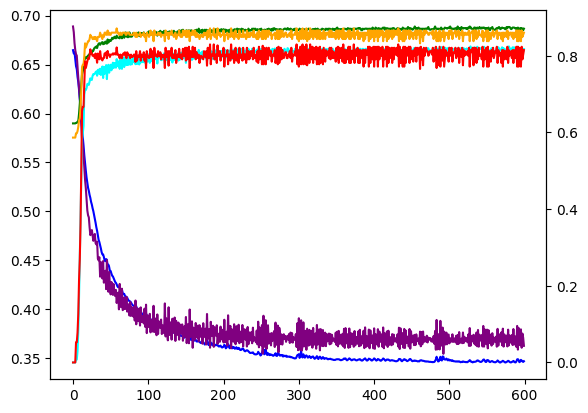

In [ ]:
epochs = range(0,params.iterations)
trainingResult = results[0]
validationResult = results[1]

fig = plt.figure()
ax1 = plt.gca()
ax1.plot(epochs,trainingResult.loss,color="blue")
ax1.plot(epochs,validationResult.loss, color="purple")
ax2 = ax1.twinx()
ax2.plot(epochs,trainingResult.accuracy,color="green")
ax2.plot(epochs,validationResult.accuracy,color="orange")
ax2.plot(epochs,trainingResult.f1_score,color="cyan")
ax2.plot(epochs,validationResult.f1_score,color="red")

valf1 = validationResult.f1_score
maxEpoch = np.argmax(valf1)


print(f"Peak cross validation f1: {valf1[maxEpoch]} at epoch {maxEpoch} with accuracy {validationResult.accuracy[maxEpoch]}. Training Acc {trainingResult.accuracy[maxEpoch]}")

These numbers seem to give us a decent model that generalizes well. Lets run this same model on ALL the data this time, using the metaparameters we got from using the cross validation set:

In [ ]:
params.iterations = maxEpoch+1
print(F"Now training on full  {unsplitData.Rows} x {unsplitData.InputCount} data set")
layers = buildLayers(hiddenLayers)
model = Model(unsplitData.InputCount,layers)
results = trainModel(dataSets=[unsplitData],model=model,loss_function=loss,trainingParams=params)
trainingResult = results[0]
a = 12

Now training on full  891 x 18 data set
Training Model. Features 18, Samples 891. Iterations: 183
Running on NVIDIA GeForce GTX 1080
returning 1 results for 1 data sets


And lets do the same analysis on the trained model to verify that it is working

Train f1 at at epoch 157: 0.826625386996904 with accuracy 0.8742985409652076


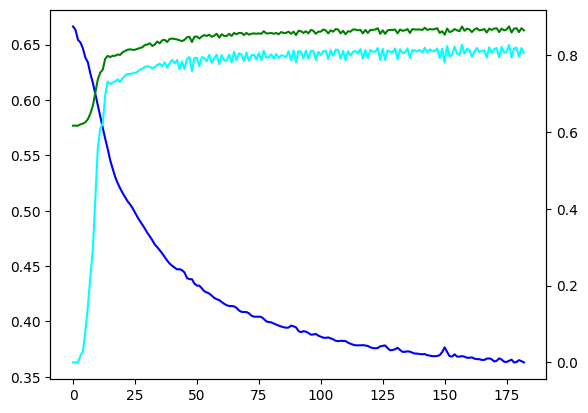

In [ ]:
fig = plt.figure()
ax1 = plt.gca()
epochs = range(0,params.iterations)
ax1.plot(epochs,trainingResult.loss,color="blue")
ax2 = ax1.twinx()
ax2.plot(epochs,trainingResult.accuracy,color="green")
ax2.plot(epochs,trainingResult.f1_score,color="cyan")

maxEpoch = np.argmax(trainingResult.f1_score)
print(f"Train f1 at at epoch {maxEpoch}: {trainingResult.f1_score[maxEpoch]} with accuracy {trainingResult.accuracy[maxEpoch]}")

Now that we have a trained model, lets run predictions on the test set. 

In [ ]:
(XTest,YTest) = SeparateData(testData)
testData = DataSet(XTest,YTest)
if torch.cuda.is_available(): testData.set_to_cuda()
X = testData.get(DataSet.X)
yHat = model.forward(X).squeeze(1)
yHat = convertToNumpy(yHat)
prediction = getPrediction(yHat)

In [ ]:
testData = pd.read_csv(testFilePath)
testData["Survived"] = prediction
testData["Survived"] = testData["Survived"].astype(int)
testData.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


Now let's verify that our results make sense

Survival rates: train:0.3838383838383838   test:0.35645933014354064


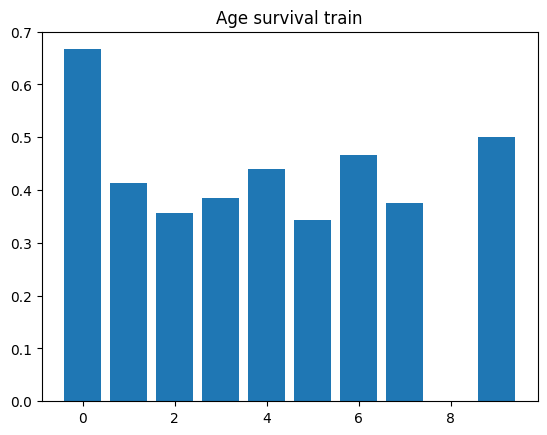

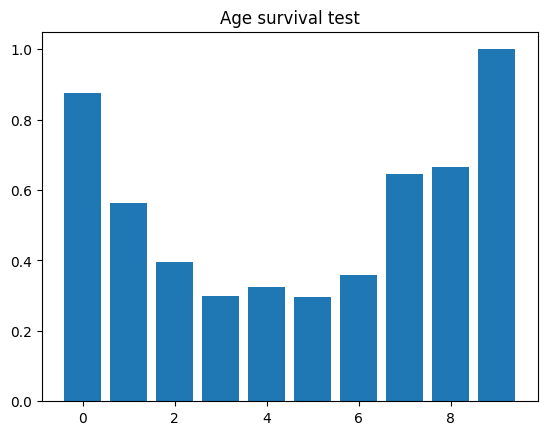

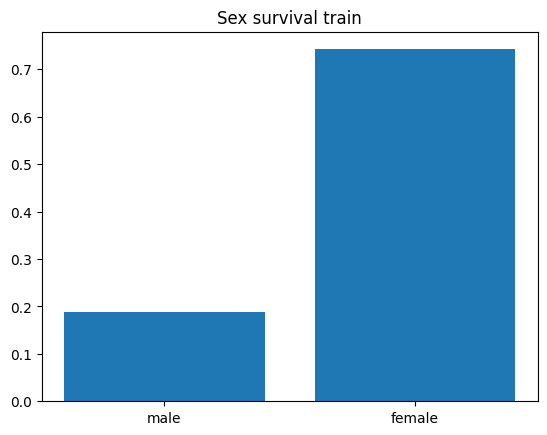

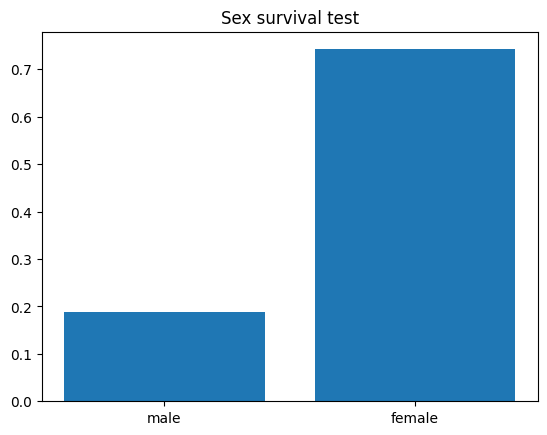

In [ ]:
def barPlotSurvivalByBrackets(data,column,bracketCount,title=""):
    x = data[column].values
    y = data["Survived"].astype(int).values

    minX = min(x)
    maxX = max(x)
    rangeX = maxX-minX
    bracketWidth = rangeX/bracketCount
    
    brackets = {}
    for i in range(bracketCount):
        brackets[i] = []

    def GetBracket(xVal):
        return (xVal-minX)//bracketWidth
    
    for (i, xVal) in enumerate(x):
        if math.isnan(xVal): continue
        bracket = GetBracket(xVal)
        brackets[bracket].append(y[i])

    newBrackets = {}
    for bracketNumber in brackets:
        minRange = minX+bracketNumber*bracketWidth
        maxRange = minRange + bracketWidth
        bracketRange = F"{int(minRange)}-{int(maxRange)}"
        newBrackets[bracketRange] = brackets[bracketNumber]


    plotBrackets(brackets,title)
    

def plotBrackets(brackets,title):
    newX = []
    newY = []
    for bracketName in brackets:
        newX.append(bracketName)
        newY.append(np.mean(brackets[bracketName]))

    plt.figure()
    plt.bar(newX,newY)
    plt.title(title)


def barPlotSurvivalByUniques(data,column,title=""):
    x = data[column]
    y = data["Survived"].astype(int).values
    unique = x.unique()
    brackets = {}
    for u in unique:
        brackets[u] = []
    
    for (i, xVal) in enumerate(x):
        brackets[xVal].append(y[i])
    
    plotBrackets(brackets,title)

def getSurvivalRate(data):
    y = data["Survived"].astype(int).values
    return sum(y)/len(y)
    

    

trainData = pd.read_csv(trainFilePath)

barPlotSurvivalByBrackets(trainData,"Age",bracketCount=10,title="Age survival train")
barPlotSurvivalByBrackets(testData,"Age",bracketCount=10,title="Age survival test")

barPlotSurvivalByUniques(trainData,"Sex",title="Sex survival train")
barPlotSurvivalByUniques(trainData,"Sex",title="Sex survival test")

print(F"Survival rates: train:{getSurvivalRate(trainData)}   test:{getSurvivalRate(testData)}")

In [ ]:

testData.to_csv("testDataWithPredicitons.csv",index=False)
testData = testData[["PassengerId","Survived"]]
testData.to_csv("submission.csv",index=False)